In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import warnings
from scipy.signal import find_peaks
warnings.filterwarnings("ignore")

In [2]:
def zscore_2d(matrix):
    matrix_mean = matrix.mean(1, keepdims=True)
    matrix_std = matrix.std(1, keepdims=True)
    return (matrix - matrix_mean) / matrix_std

In [3]:
def get_freq(sampling_rate, level):
    freqs = []
    freq_top = sampling_rate * 0.5
    for i in range(1, level+1):
        start, end = freq_top * 0.5, freq_top
        freqs.append((start, end))
        freq_top = start
    freqs.append((0, freq_top))
    return freqs[::-1]

In [4]:
def load_RealData():
    traindata_path = '../../Data/RealData/all_back_train.npy'
    testdata_path = '../../Data/RealData/all_back_test.npy'

    train_data, test_data = np.load(traindata_path), np.load(testdata_path)
    signals_train, labels_train = train_data[:, :1000], train_data[:, 1000:]
    signals_test, labels_test = test_data[:, :1000], test_data[:, 1000:]

    print(signals_train.shape, labels_test.shape)

    return labels_train, labels_test, zscore_2d(signals_train), zscore_2d(signals_test)

In [5]:
def wavelet_denoise_select(signals, level, wavelet, sampling_rate, show=False):
    filtered_signals = []
    for signal in signals:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        dep_freqs = get_freq(sampling_rate, level)

        coeffs_filtered = [np.zeros_like(coeffs[0])] + coeffs[1:5] + [np.zeros_like(c) for c in coeffs[5:]]
        reconstructed_signal = pywt.waverec(coeffs_filtered, wavelet)
        if show:
            print(dep_freqs[1:5])
            plt.figure(figsize=(12, 5))
            plt.plot(signal, label='Noisy Signal')
            plt.plot(reconstructed_signal, label='Filtered Signal')
            plt.legend()
            plt.show()
            break

        filtered_signals.append(reconstructed_signal)
        # break
    return np.array(filtered_signals)

In [6]:
def check_uncertain(signal, window, threshold_uncertain=0.2):
    end = len(signal)
    pieces_indexes = [(start, min(start + window, end)) for start in range(0, end, window)]
    pieced_signals = [signal[begin: over] for begin, over in pieces_indexes]

    def cal_energy(piece):
        return np.sum(np.square(piece))

    pieced_energy = [cal_energy(pieced_signal) for pieced_signal in pieced_signals]

    delta_pieced_energy = np.abs(np.diff(pieced_energy)) / pieced_energy[:-1]
    # delta_pieced_energy = np.array(pieced_energy[1:]) / pieced_energy[:-1]

    if np.sum(delta_pieced_energy <= threshold_uncertain) == len(delta_pieced_energy):
        # 全部符合标准，说明并没有不确定性
        uncertain = 0
    else:
        uncertain = 1

    return uncertain

def zcr_and_status(signals, threshold=0.13):
    zcrs, status = [], []

    for cnt, signal in enumerate(signals):
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossings_rate = len(zero_crossings) / (len(signal)-1)
        zcrs.append(zero_crossings_rate)

        # 确定是否是uncertain的状态
        uncertain_bool = check_uncertain(signal, window=200)
        if uncertain_bool:
            status.append(-1)
        else:
            if zero_crossings_rate > threshold:
                status.append(0)
            else:
                status.append(1)

    return np.array(zcrs), np.array(status)

In [7]:
def re_status(signals, initial_statuses):
    """I don't need to implement it now."""
    return initial_statuses

def get_good_signals(signals, statuses, zcrs):
    good_signals_idx = []
    for cnt, (status, zcr) in enumerate(zip(statuses, zcrs)):
        if status == 1 and zcr < 0.125:
            good_signals_idx.append(cnt)
    # print(good_signals_idx)
    return signals[good_signals_idx], np.array(good_signals_idx)

In [8]:
# acf
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    acf = np.correlate(signal - mean, signal - mean, mode='full') / (np.var(signal) * n)
    return acf[n-1:]

def get_acfs(envelopes):
    acfs = []
    for env in envelopes:
        acf = autocorrelation(env)
        acfs.append(acf)
    return np.array(acfs)

In [43]:
def segmentation_nk2(signals, envelopes, labels, alpha, resample_rate):

    show = False
    all_pieces = []
    for cnt in range(len(signals)):

        envelope = envelopes[cnt]
        hr = labels[cnt, 2]
        signal = signals[cnt]
        peaks_temp, _ = find_peaks(envelope, height=np.max(envelope) * 0.15, distance=(int(5500*resample_rate) // hr))
        peaks_dis_mean = np.int(np.mean(np.diff(peaks_temp)))

        peaks, _ = find_peaks(envelope, height=np.max(envelope) * alpha, distance=(int(5000*resample_rate) // hr))

        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(envelope)
            plt.plot(signal)
            plt.scatter(peaks ,envelope[peaks])
            plt.show()

        # epoch_start, epoch_end = int(0.45 * peaks_dis_mean), int(0.5 * peaks_dis_mean)
        epoch_start, epoch_end = int(0.6 * peaks_dis_mean), int(0.6 * peaks_dis_mean)

        pieces = []
        # print(len(peaks))
        # plt.figure(figsize=(12, 5))
        for i in range(len(peaks)):
            if peaks[i] - epoch_start < 0:
                continue
            if peaks[i] + epoch_end > int(1000*resample_rate):
                break

            start = peaks[i] - epoch_start
            end = peaks[i] + epoch_end
            # print(end-start, start, end)
            piece = signal[start: end]
            # print(len(piece))
            pieces.append(piece)
            # plt.plot(piece)
        # plt.show()
        all_pieces.append(pieces)

        if show:
            plt.figure(figsize=(12, 3))
            for line, piece in enumerate(pieces):
                plt.plot(piece, label=str(line))
            plt.legend()
            plt.show()
    return all_pieces

In [44]:
# # energy
def cal_energy(signals, window=32):
    show = False
    energies = []
    for cnt in range(len(signals)):
        signal = signals[cnt]

        signal_padded = np.pad(signal, [window//2, window//2], 'constant', constant_values=(0, 0))

        squared_signal = np.square(signal_padded)

        start = 0
        end = 0
        signal_energy = []
        for i in range(len(signal_padded)-window):
            start = i
            end = i + window
            signal_energy.append(np.sum(squared_signal[start:end]) / window)

        energies.append(np.array(signal_energy))
        if show:
            plt.figure(figsize=(12, 3))
            plt.plot(signal)
            plt.plot(signal_energy)
            plt.show()
    return energies

In [45]:
def find_last_zero_position(arr):
    zero_indices = np.where(arr == 0)[0]

    for zero_pos in zero_indices:
        if zero_pos <= 3:
            continue
        if arr[zero_pos-3] == 0 and arr[zero_pos-2] == 0 and arr[zero_pos-1] == 0 and arr[zero_pos+1] != 0:
            return zero_pos
    if len(zero_indices) > 0:
        return zero_indices[-1]
    else:
        return -1

def re_align(all_pieces):
    realigned_all_pieces = []
    for cnt, pieces in enumerate(all_pieces):
        padded_pieces = []
        for piece in pieces:
            padded_pieces.append(np.pad(piece, (35, 35), 'constant'))

        padded_pieces = np.array(padded_pieces)

        for i in range(len(padded_pieces)):
            time_series2 = padded_pieces[i]
            ccf_results = 0

            for j in range(len(padded_pieces)):
                if i == j:
                    continue
                time_series1 = padded_pieces[j]
                ccf_result = np.correlate(time_series1 - np.mean(time_series1), time_series2 - np.mean(time_series2), mode='full') / (np.std(time_series1) * np.std(time_series2) * len(time_series1))
                ccf_results += ccf_result

            lags = np.arange(-len(time_series1) + 1, len(time_series2))
            max_correlation_index = np.argmax(ccf_results)
            optimal_lag = lags[max_correlation_index]

            if optimal_lag > 30:
                optimal_lag = 30
            elif optimal_lag < -30:
                optimal_lag = -30
            new_time_series2 = np.roll(time_series2, optimal_lag)
            padded_pieces[i] = new_time_series2


        zero_start_max, zero_end_max = 0, 0
        for piece in padded_pieces:
            zero_start = find_last_zero_position(piece)
            zero_end = find_last_zero_position(piece[::-1])

            zero_start_max = max(zero_start, zero_start_max)
            zero_end_max = max(zero_end, zero_end_max)
        realigned_all_pieces.append(np.array(padded_pieces)[:, zero_start_max:-zero_end_max])

    return realigned_all_pieces

In [46]:
from DBA import performDBA_
from scipy.signal import resample_poly

labels_train, labels_test, signals_train, signals_test = load_RealData()
wavelet = 'db12'
level = 6
sampling_rate = 100

filtered_signals = wavelet_denoise_select(signals_train, level, wavelet, sampling_rate)

print(filtered_signals.shape)
zcrs, statuses = zcr_and_status(filtered_signals)

final_statuses = re_status(filtered_signals, statuses)
good_signals, good_signals_index = get_good_signals(filtered_signals, final_statuses, zcrs)
print(good_signals.shape)
good_labels = labels_train[good_signals_index]
print(good_labels.shape)

def resample_signals(signals, resample_rate):
    resampled_signals = [resample_poly(signal, int(1000*resample_rate), 1000) for signal in signals]
    return np.array(resampled_signals)

resample_rate = 1.5
good_signals = resample_signals(good_signals, 1.5)
energies_32 = cal_energy(good_signals, window=int(48*resample_rate))

all_pieces_energy_32 = segmentation_nk2(good_signals, energies_32, good_labels, 0.5, 1.5)

realigned_all_pieces = re_align(all_pieces_energy_32)

(4672, 1000) (1655, 6)
(4672, 1000)
(270, 1000)
(270, 6)


In [47]:
scgs = [38, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
bad_qualities = [39, 40, 41, 42, 53, 54, 55, 56, 57, 58, 59, 95 ]
# 71-94, 99-131
phases = [142, 143, 155, 166, 168, 169, 171, 173, 175]
178-201

-23

In [61]:
first_ = [19, 24, 27 , 96, 147,  149, 167]
# 0-14, 43-52
second_ = [16, 17, 18, 20, 21, 22, 23, 25, 26, 28, 97, 98, 144, 145, 146, 148,150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 162, 162, 164, 165]
# 28 - 37, 132-139
third_ = [15, 60, 140, 141, ]

14 28 42


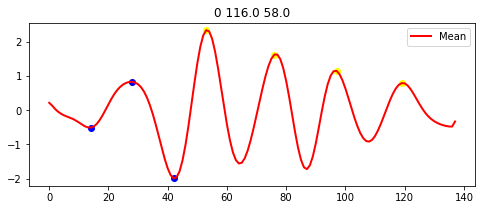

14 25 42


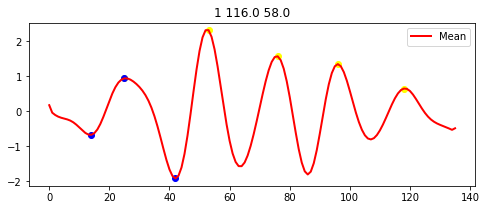

12 26 42


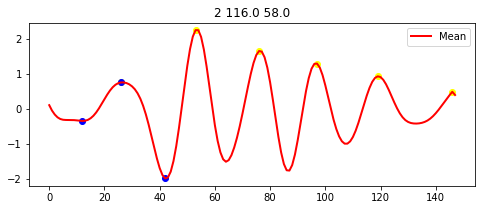

15 30 44


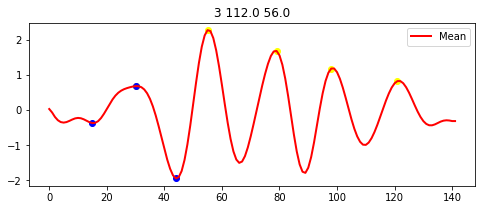

16 28 45


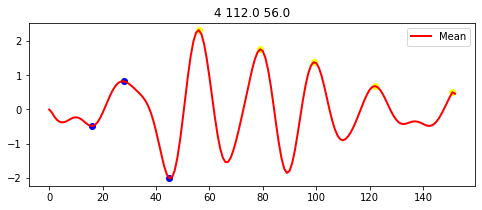

14 29 43


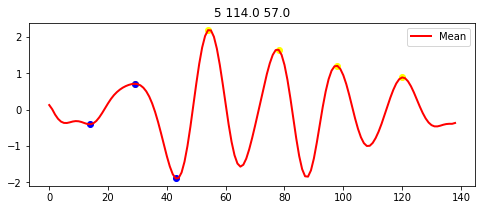

14 26 43


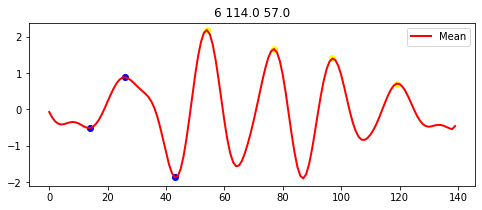

15 30 44


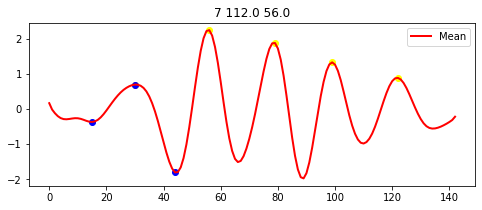

14 26 44


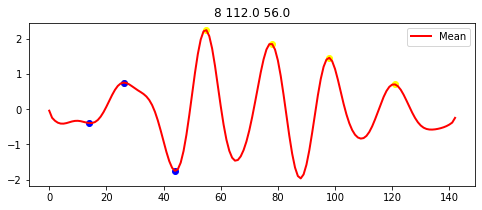

12 27 43


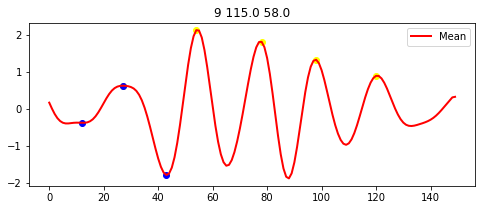

14 26 44


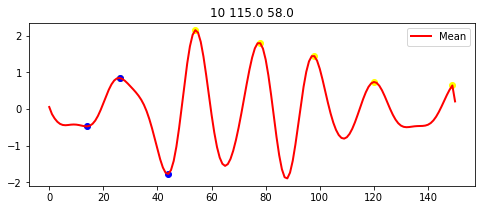

21 33 48


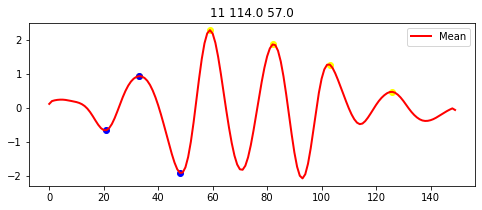

37 51 61


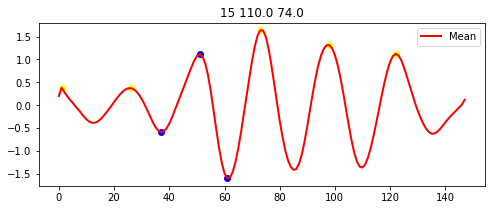

36 52 63


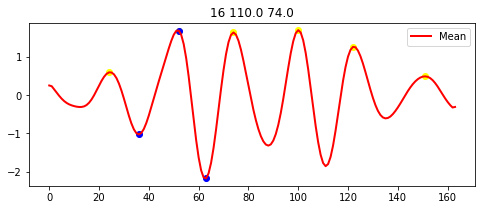

37 53 64


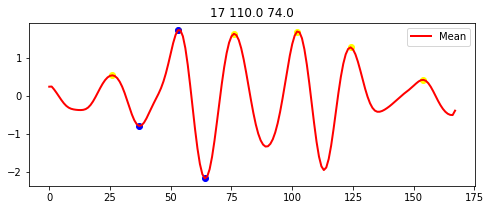

33 49 60


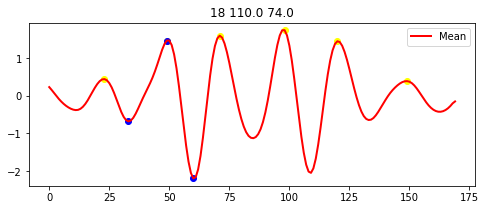

32 49 60


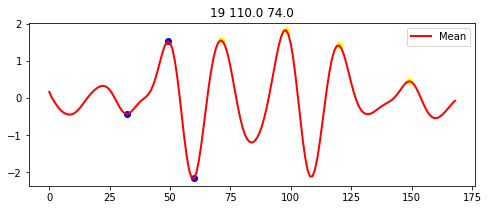

35 52 62


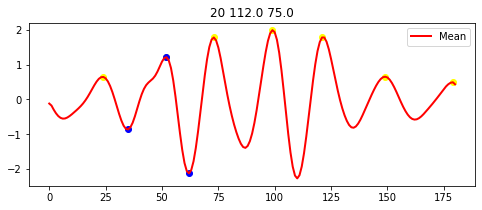

34 51 61


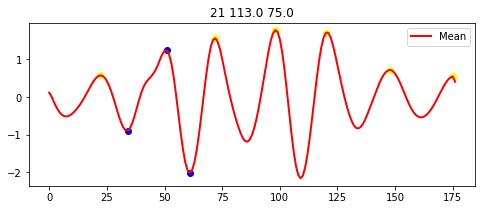

33 51 62


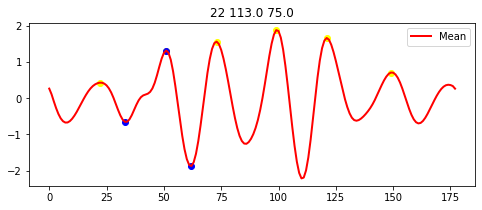

23 39 51


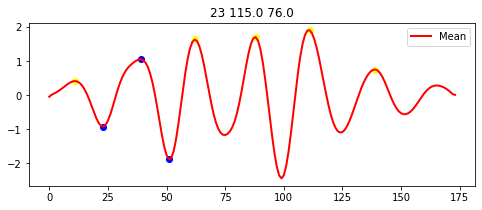

35 51 63


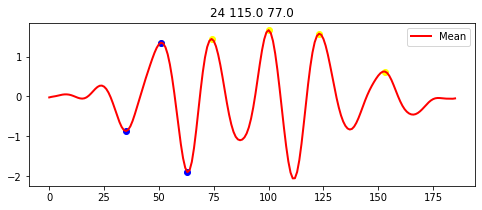

32 48 60


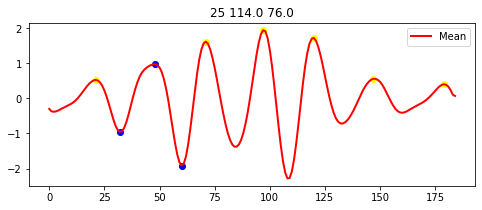

32 49 60


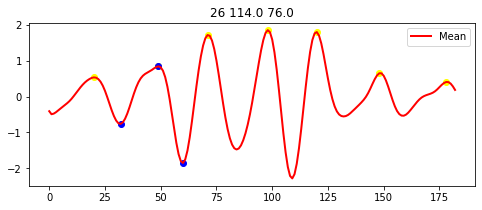

13 28 41


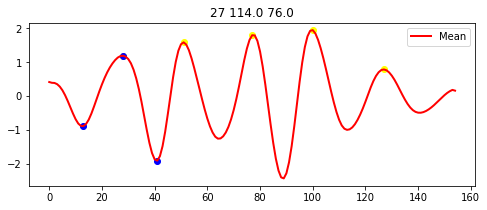

35 51 62


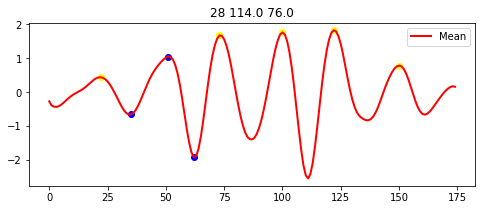

32 49 60


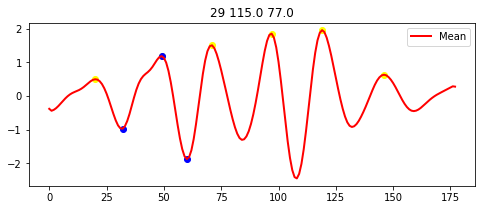

33 51 62


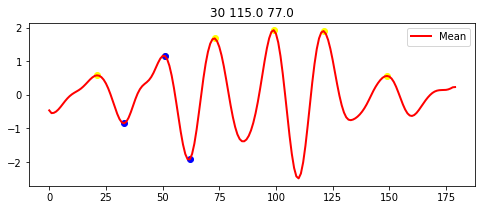

34 51 62


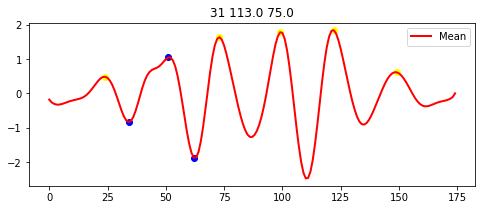

28 43 55


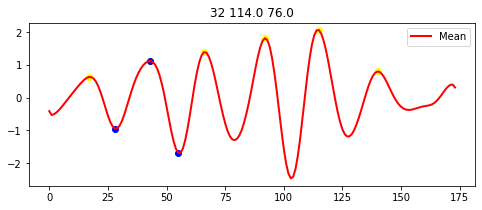

28 43 55


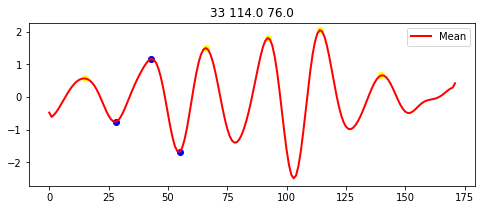

37 56 66


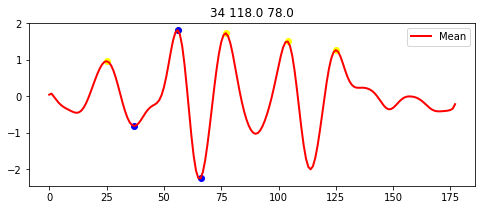

38 55 66


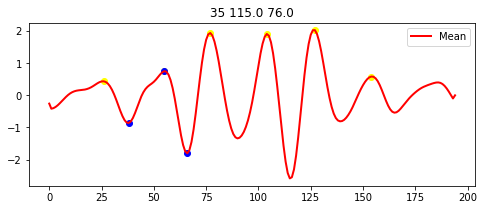

17 27 45


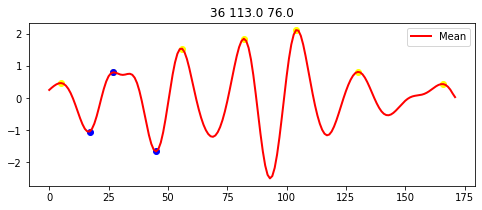

35 50 62


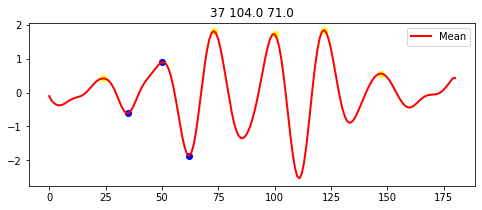

9 28 38
10 20 38
22 40 51
10 21 38
26 36 55
26 37 54
22 39 51
3 19 32
28 38 57
33 43 62
41 51 70
10 25 37
22 35 49
34 50 61
18 33 44
17 32 42
17 34 44
17 34 43
16 32 42
17 32 42
18 33 44
18 33 43
37 53 64
37 53 63
25 39 51
14 29 40
17 31 43
6 20 31
19 34 45
1 14 27
20 35 46
26 41 52
34 49 60
36 51 62
18 33 44
17 31 43
24 39 50
17 32 43
17 32 43
18 33 44
26 41 53
26 40 52
18 33 45
18 34 45
2 18 32


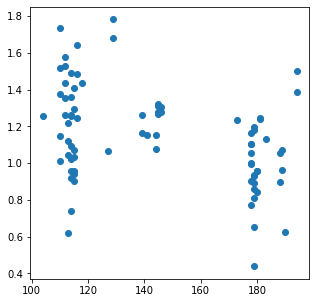

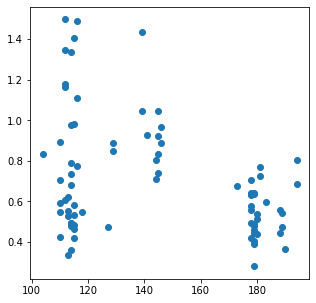

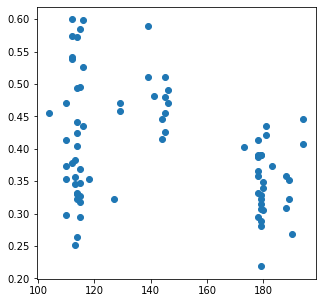

In [82]:
from tslearn.barycenters import softdtw_barycenter
JK_minus_IJ_ls = []
JK_minus_IJ_divide_IJ_ls = []
JK_minus_IJ_divide_JK_ls = []
S = []
D = []
for cnt, pieces in enumerate(all_pieces_energy_32):

    if (cnt in scgs) or (cnt in bad_qualities) or (cnt in phases) or (cnt >= 71 and cnt <= 94) or (cnt >=99 and cnt <=131):
        continue
    signal = good_signals[cnt]
    s = good_labels[cnt, -2]
    d = good_labels[cnt, -1]
    realigned_pieces = realigned_all_pieces[cnt]

    # template = performDBA(pieces)

    template_mean = np.mean(realigned_pieces, axis=0)
    # template_median = np.median(realigned_pieces, axis=0)

    peaks, _ = find_peaks(template_mean, height=np.max(template_mean) * 0.2, distance=10)

    if (cnt in first_) or (cnt >= 0 and cnt <=11) or (cnt >= 43 and cnt <= 52):
        J_index = peaks[0]
        # pass
    elif (cnt in second_) or (cnt >=28 and cnt <= 37) or (cnt >= 132 and cnt <=139):
        J_index = peaks[1]
        # pass
    elif cnt in third_:
        J_index = peaks[2]
        # pass
    else:
        continue

    first_4_peaks = peaks[: 4]
    minus_template_mean_4 = -1 * template_mean[: first_4_peaks[-1]]
    minus_peaks_4, _ = find_peaks(minus_template_mean_4, height=np.max(minus_template_mean_4) * 0.1)

    I_possible_indices = np.where(minus_peaks_4 < J_index)[0]
    max_index = np.argmax(minus_peaks_4[I_possible_indices])
    I_index = minus_peaks_4[I_possible_indices][max_index]

    K_possible_indices = np.where(minus_peaks_4 > J_index)[0]
    max_index = np.argmin(minus_peaks_4[K_possible_indices])
    K_index = minus_peaks_4[K_possible_indices][max_index]
    print(I_index, J_index, K_index)

    J = template_mean[J_index]
    I = template_mean[I_index]
    K = template_mean[K_index]

    JK = J - K
    IJ = J - I

    JK_minus_IJ = JK - IJ
    JK_minus_IJ_divide_IJ = (JK - IJ) / IJ
    JK_minus_IJ_divide_JK = (JK - IJ) / JK

    S.append(s)
    D.append(d)
    JK_minus_IJ_ls.append(JK_minus_IJ)
    JK_minus_IJ_divide_IJ_ls.append(JK_minus_IJ_divide_IJ)
    JK_minus_IJ_divide_JK_ls.append(JK_minus_IJ_divide_JK)

    if s < 120:
        plt.figure(figsize=(8, 3))
        plt.title(str(cnt) + ' ' + str(s) + ' ' + str(d))
        plt.plot(template_mean, color='red', linewidth=2, label='Mean')
        plt.scatter(peaks, template_mean[peaks], color='yellow')
        plt.scatter(I_index, template_mean[I_index], color='blue')
        plt.scatter(J_index, template_mean[J_index], color='blue')
        plt.scatter(K_index, template_mean[K_index], color='blue')

    # plt.plot(template_median, color='red', linewidth=2, label='Median')
    # template,  tolerance = performDBA_(realigned_pieces)
    # plt.plot(template, color='red', linewidth=2, label='Template_DBA')
    # plt.plot(template + tolerance, linewidth=1, color='gray', label='DBA_up')
    # plt.plot(template - tolerance, linewidth=1, color='gray', label='DBA_down')
        plt.legend()
        plt.show()


    if cnt > 176:
        break

plt.figure(figsize=(5,5))
plt.scatter(S, JK_minus_IJ_ls)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(S, JK_minus_IJ_divide_IJ_ls)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(S, JK_minus_IJ_divide_JK_ls)
plt.show()

# plt.figure(figsize=(5,5))
# plt.scatter(D, JK_minus_IJ_ls)
# plt.show()
#
# plt.figure(figsize=(5,5))
# plt.scatter(D, JK_minus_IJ_divide_IJ_ls)
# plt.show()
#
# plt.figure(figsize=(5,5))
# plt.scatter(D, JK_minus_IJ_divide_JK_ls)
# plt.show()

14 28 42
14 25 42
12 26 42
15 30 44
16 28 45
14 29 43
14 26 43
15 30 44
14 26 44
12 27 43
14 26 44
21 33 48
37 51 61
36 52 63
37 53 64
33 49 60
32 49 60
35 52 62
34 51 61
33 51 62
23 39 51
35 51 63
32 48 60
32 49 60
13 28 41
35 51 62
32 49 60
33 51 62
34 51 62
28 43 55
28 43 55
37 56 66
38 55 66
17 27 45
35 50 62
9 28 38
10 20 38
22 40 51
10 21 38
26 36 55
26 37 54
22 39 51
3 19 32
28 38 57
33 43 62
41 51 70
10 25 37
22 35 49
34 50 61
18 33 44


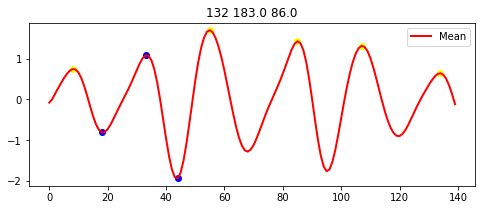

17 32 42


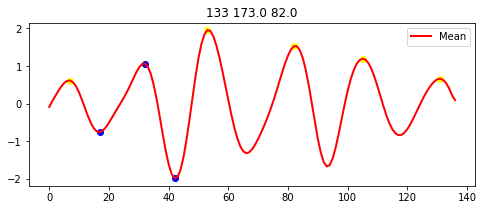

17 34 44


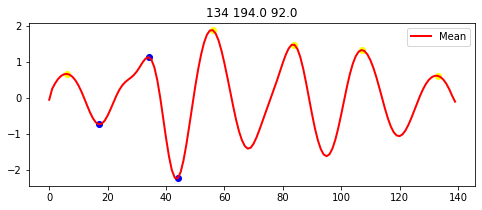

17 34 43


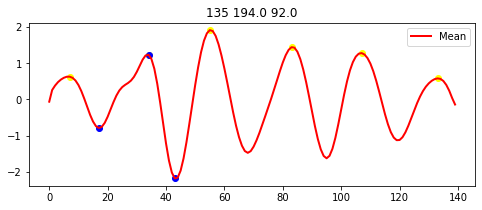

16 32 42


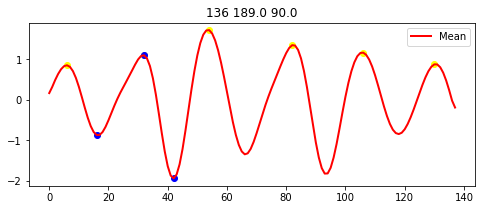

17 32 42


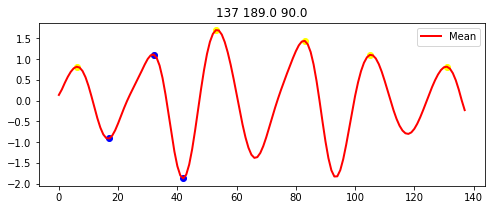

18 33 44


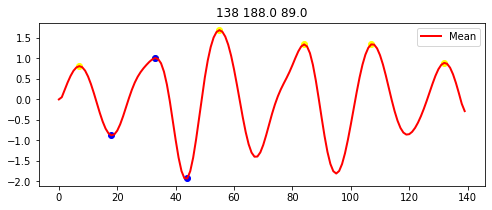

18 33 43


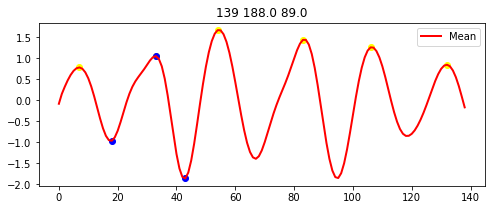

37 53 64


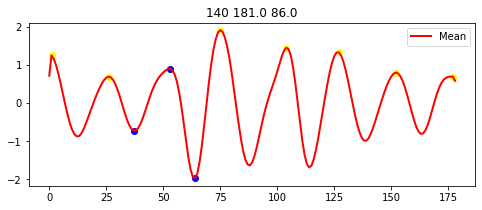

37 53 63


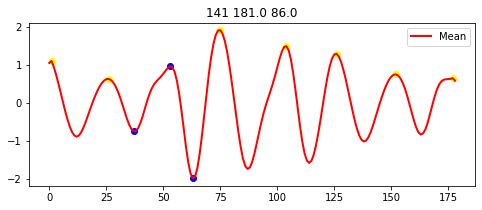

25 39 51


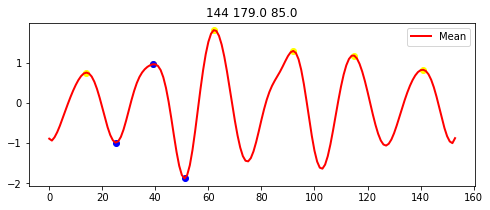

14 29 40


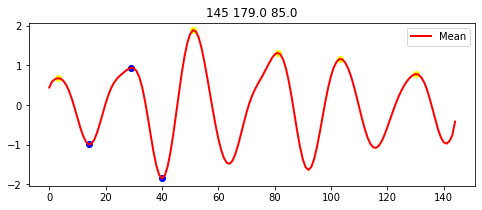

17 31 43


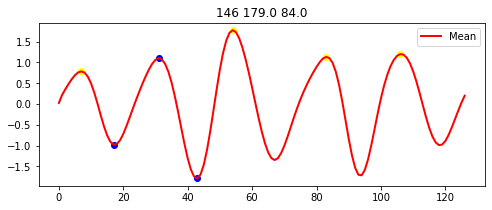

6 20 31


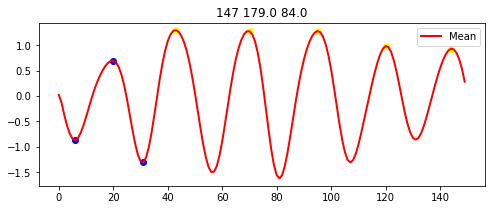

19 34 45


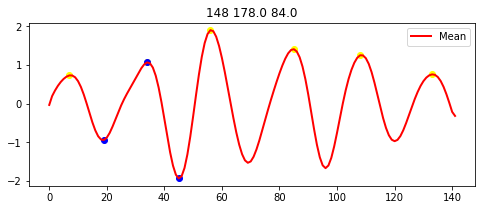

1 14 27


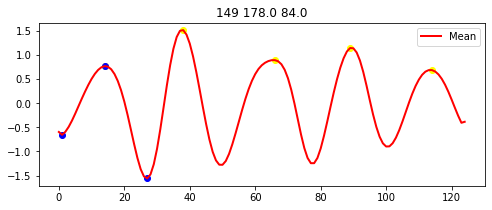

20 35 46


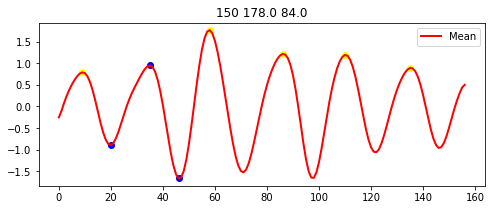

26 41 52


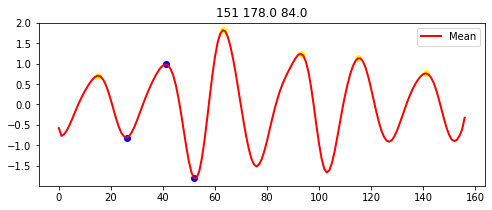

34 49 60


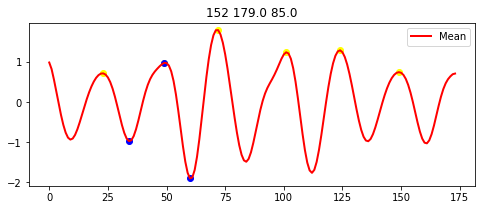

36 51 62


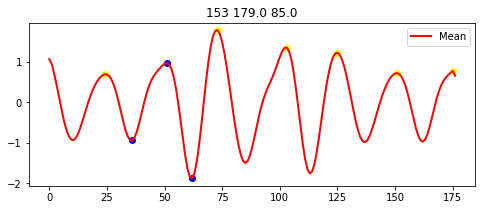

18 33 44


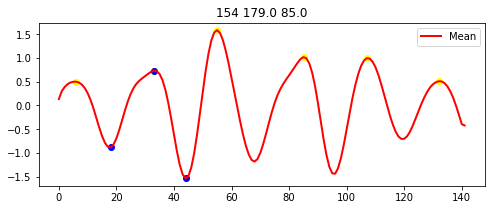

17 31 43


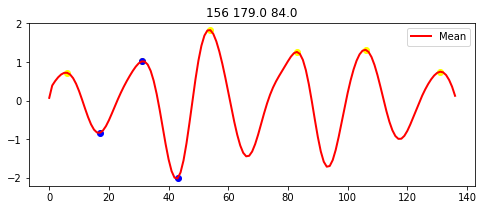

24 39 50


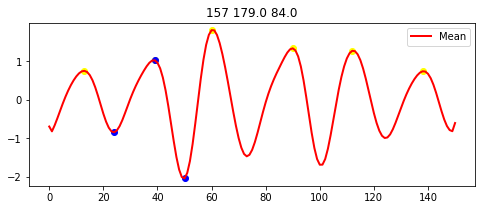

17 32 43


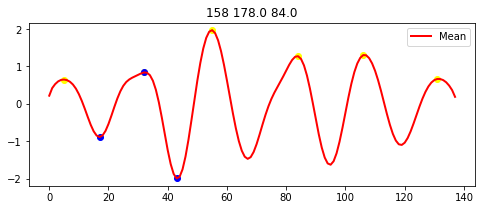

17 32 43


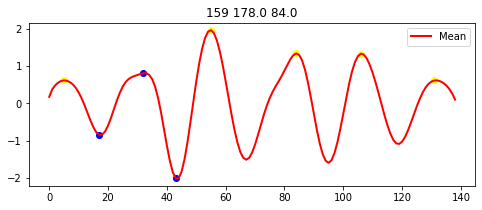

18 33 44


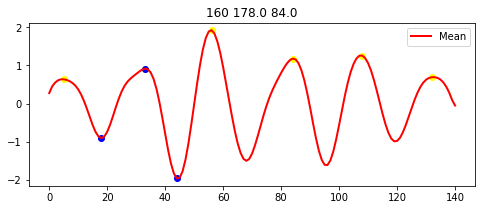

26 41 53


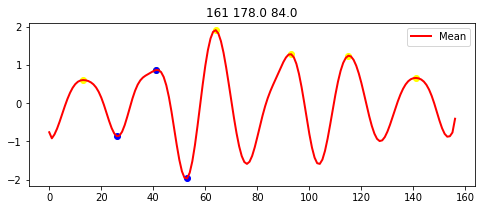

26 40 52


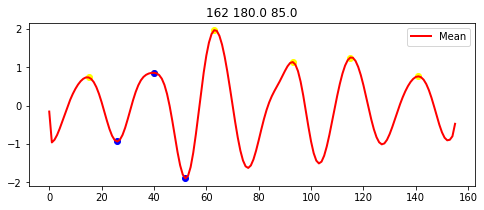

18 33 45


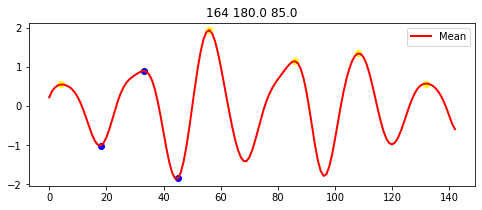

18 34 45


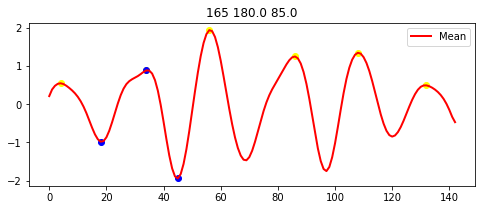

2 18 32


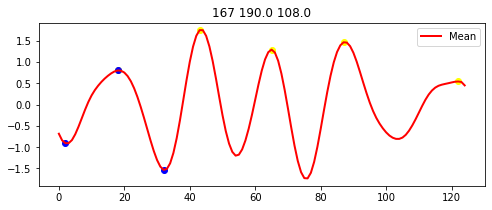

In [83]:
from tslearn.barycenters import softdtw_barycenter
JK_minus_IJ_ls = []
JK_minus_IJ_divide_IJ_ls = []
JK_minus_IJ_divide_JK_ls = []
S = []
D = []
for cnt, pieces in enumerate(all_pieces_energy_32):

    if (cnt in scgs) or (cnt in bad_qualities) or (cnt in phases) or (cnt >= 71 and cnt <= 94) or (cnt >=99 and cnt <=131):
        continue
    signal = good_signals[cnt]
    s = good_labels[cnt, -2]
    d = good_labels[cnt, -1]
    realigned_pieces = realigned_all_pieces[cnt]

    # template = performDBA(pieces)

    template_mean = np.mean(realigned_pieces, axis=0)
    # template_median = np.median(realigned_pieces, axis=0)

    peaks, _ = find_peaks(template_mean, height=np.max(template_mean) * 0.2, distance=10)

    if (cnt in first_) or (cnt >= 0 and cnt <=11) or (cnt >= 43 and cnt <= 52):
        J_index = peaks[0]
        # pass
    elif (cnt in second_) or (cnt >=28 and cnt <= 37) or (cnt >= 132 and cnt <=139):
        J_index = peaks[1]
        # pass
    elif cnt in third_:
        J_index = peaks[2]
        # pass
    else:
        continue

    first_4_peaks = peaks[: 4]
    minus_template_mean_4 = -1 * template_mean[: first_4_peaks[-1]]
    minus_peaks_4, _ = find_peaks(minus_template_mean_4, height=np.max(minus_template_mean_4) * 0.1)

    I_possible_indices = np.where(minus_peaks_4 < J_index)[0]
    max_index = np.argmax(minus_peaks_4[I_possible_indices])
    I_index = minus_peaks_4[I_possible_indices][max_index]

    K_possible_indices = np.where(minus_peaks_4 > J_index)[0]
    max_index = np.argmin(minus_peaks_4[K_possible_indices])
    K_index = minus_peaks_4[K_possible_indices][max_index]
    print(I_index, J_index, K_index)

    J = template_mean[J_index]
    I = template_mean[I_index]
    K = template_mean[K_index]

    JK = J - K
    IJ = J - I

    JK_minus_IJ = JK - IJ
    JK_minus_IJ_divide_IJ = (JK - IJ) / IJ
    JK_minus_IJ_divide_JK = (JK - IJ) / JK

    S.append(s)
    D.append(d)
    JK_minus_IJ_ls.append(JK_minus_IJ)
    JK_minus_IJ_divide_IJ_ls.append(JK_minus_IJ_divide_IJ)
    JK_minus_IJ_divide_JK_ls.append(JK_minus_IJ_divide_JK)

    if s > 160:
        plt.figure(figsize=(8, 3))
        plt.title(str(cnt) + ' ' + str(s) + ' ' + str(d))
        plt.plot(template_mean, color='red', linewidth=2, label='Mean')
        plt.scatter(peaks, template_mean[peaks], color='yellow')
        plt.scatter(I_index, template_mean[I_index], color='blue')
        plt.scatter(J_index, template_mean[J_index], color='blue')
        plt.scatter(K_index, template_mean[K_index], color='blue')

    # plt.plot(template_median, color='red', linewidth=2, label='Median')
    # template,  tolerance = performDBA_(realigned_pieces)
    # plt.plot(template, color='red', linewidth=2, label='Template_DBA')
    # plt.plot(template + tolerance, linewidth=1, color='gray', label='DBA_up')
    # plt.plot(template - tolerance, linewidth=1, color='gray', label='DBA_down')
        plt.legend()
        plt.show()


    if cnt > 176:
        break